In [1]:
import yfinance as yf
import pandas as pd
import numpy as np

In [ ]:
vix = yf.Ticker("^INDIAVIX")
nifty = yf.Ticker("^NSEI")
nifty_data = nifty.history(period="10y", interval="1d")
vix_data = vix.history(period="10y ", interval="1d")

In [3]:
nifty_data['LogRet'] = np.log(nifty_data['Close'] / nifty_data['Close'].shift(1))
vix_data['LogRet'] = np.log(vix_data['Close'] / vix_data['Close'].shift(1))
squared_ret_nifty = np.square(nifty_data['LogRet'])
squared_ret_vix = np.square(vix_data['LogRet'])

In [4]:
nifty_data['ReturnSquared'] = squared_ret_nifty
vix_data['ReturnSquared'] = squared_ret_vix
nifty_data = nifty_data.dropna()
vix_data = vix_data.dropna()
vix_data = vix_data['ReturnSquared']
nifty_data = nifty_data['ReturnSquared']
merged_df = pd.merge(nifty_data, vix_data, left_index=True, right_index=True, suffixes=('_Nifty', '_VIX'))
merged_df = merged_df.dropna()
merged_df

,ReturnSquared_Nifty,ReturnSquared_VIX
Date,,
2015-11-03 00:00:00+05:30,1.510403e-06,0.000017
2015-11-04 00:00:00+05:30,6.484371e-06,0.000106
2015-11-05 00:00:00+05:30,1.122907e-04,0.000013
2015-11-06 00:00:00+05:30,2.091337e-08,0.000086
2015-11-09 00:00:00+05:30,2.428176e-05,0.017772
...,...,...
2025-10-27 00:00:00+05:30,4.360543e-05,0.000530
2025-10-28 00:00:00+05:30,1.323189e-06,0.000057
2025-10-29 00:00:00+05:30,2.050132e-05,0.000003


In [5]:
global_min = merged_df.min().min()
global_max = merged_df.max().max()
num_bins = 10
log_min_power = np.log10(max(1e-7, global_min))
log_max_power = np.log10(global_max)
#bin_edges_arr = np.linspace(global_min, global_max, num_bins + 1)
bin_edges_hybrid = np.logspace(log_min_power, log_max_power, num_bins + 1)

print(f"global bin range : {merged_df.min().min()} to {merged_df.max().max()  }")
print(f"bins : {bin_edges_hybrid}")

global bin range : 0.0 to 0.2545767917393273
bins : [1.00000000e-07 4.37101081e-07 1.91057355e-06 8.35113766e-06
 3.65029130e-05 1.59554628e-04 6.97415002e-04 3.04840852e-03
 1.33246266e-02 5.82420869e-02 2.54576792e-01]


In [6]:
def shannon_entropy(window_values, bins_array):
    counts, _ = np.histogram(window_values, bins=bins_array)
    p = counts / counts.sum() if counts.sum() !=0 else np.zeros_like(counts)
    p = p[p > 0]
    H = -np.sum(p * np.log(p))
    return H

In [7]:
W = 60
Ht_nifty = []
Ht_vix = []
dates = []

for i in range(W, len(merged_df)):
    window_nifty = merged_df["ReturnSquared_Nifty"].iloc[i - W:i]
    window_vix = merged_df["ReturnSquared_VIX"].iloc[i - W:i]
    
    # Compute entropies
    H_nifty = shannon_entropy(window_nifty, bin_edges_hybrid)
    H_vix = shannon_entropy(window_vix, bin_edges_hybrid)
    
    
    Ht_nifty.append(H_nifty)
    Ht_vix.append(H_vix)
    dates.append(merged_df.index[i])  # assign to window-end date

In [8]:
entropy_df = pd.DataFrame({
    "H_NIFTY": Ht_nifty,
    "H_VIX": Ht_vix
}, index=pd.to_datetime(dates))

In [9]:
entropy_df

,H_NIFTY,H_VIX
2016-02-03 00:00:00+05:30,1.586742,1.775843
2016-02-04 00:00:00+05:30,1.572104,1.740664
2016-02-05 00:00:00+05:30,1.564727,1.742181
2016-02-08 00:00:00+05:30,1.564727,1.742181
2016-02-09 00:00:00+05:30,1.565783,1.747795
...,...,...
2025-10-27 00:00:00+05:30,1.345264,1.721746
2025-10-28 00:00:00+05:30,1.351259,1.720749
2025-10-29 00:00:00+05:30,1.351259,1.729051
2025-10-30 00:00:00+05:30,1.351259,1.748914


In [10]:
entropy_df["H_DIFF"] = entropy_df["H_NIFTY"] - entropy_df["H_VIX"]
L = 252
entropy_df["H_DIFF_MEAN"] = entropy_df["H_DIFF"].rolling(L).mean()
entropy_df["H_DIFF_STD"] = entropy_df["H_DIFF"].rolling(L).std()
entropy_df["CAVE"] = (entropy_df["H_DIFF"] - entropy_df["H_DIFF_MEAN"]) / entropy_df["H_DIFF_STD"]
entropy_df = entropy_df.dropna()
entropy_df

,H_NIFTY,H_VIX,H_DIFF,H_DIFF_MEAN,H_DIFF_STD,CAVE
2017-02-10 00:00:00+05:30,1.563981,1.456407,0.107574,-0.036372,0.104159,1.381987
2017-02-13 00:00:00+05:30,1.562630,1.500307,0.062323,-0.035375,0.103894,0.940356
2017-02-14 00:00:00+05:30,1.562630,1.500307,0.062323,-0.034459,0.103733,0.932986
2017-02-15 00:00:00+05:30,1.548540,1.490502,0.058038,-0.033524,0.103500,0.884654
2017-02-16 00:00:00+05:30,1.548540,1.490502,0.058038,-0.032590,0.103258,0.877676
...,...,...,...,...,...,...
2025-10-27 00:00:00+05:30,1.345264,1.721746,-0.376482,-0.057159,0.136171,-2.345008
2025-10-28 00:00:00+05:30,1.351259,1.720749,-0.369490,-0.059377,0.136690,-2.268725
2025-10-29 00:00:00+05:30,1.351259,1.729051,-0.377792,-0.061631,0.137241,-2.303696
2025-10-30 00:00:00+05:30,1.351259,1.748914,-0.397655,-0.063952,0.137959,-2.418854


In [11]:
entropy_df.tail(20)

,H_NIFTY,H_VIX,H_DIFF,H_DIFF_MEAN,H_DIFF_STD,CAVE
2025-10-03 00:00:00+05:30,1.377440,1.611351,-0.233911,-0.031967,0.126155,-1.600754
2025-10-06 00:00:00+05:30,1.377440,1.610443,-0.233003,-0.033269,0.126531,-1.578533
2025-10-07 00:00:00+05:30,1.356859,1.610443,-0.253584,-0.034663,0.127017,-1.723556
2025-10-08 00:00:00+05:30,1.369781,1.610443,-0.240661,-0.035875,0.127520,-1.605908
2025-10-09 00:00:00+05:30,1.390362,1.610443,-0.220080,-0.036950,0.127928,-1.431510
2025-10-10 00:00:00+05:30,1.366463,1.610443,-0.243980,-0.038290,0.128322,-1.602916
2025-10-13 00:00:00+05:30,1.366463,1.638248,-0.271785,-0.039777,0.128849,-1.800621
2025-10-14 00:00:00+05:30,1.344140,1.663564,-0.319424,-0.041454,0.129729,-2.142706
2025-10-15 00:00:00+05:30,1.344140,1.653990,-0.309850,-0.043160,0.130421,-2.044841
2025-10-16 00:00:00+05:30,1.347458,1.675463,-0.328005,-0.044813,0.131381,-2.155506


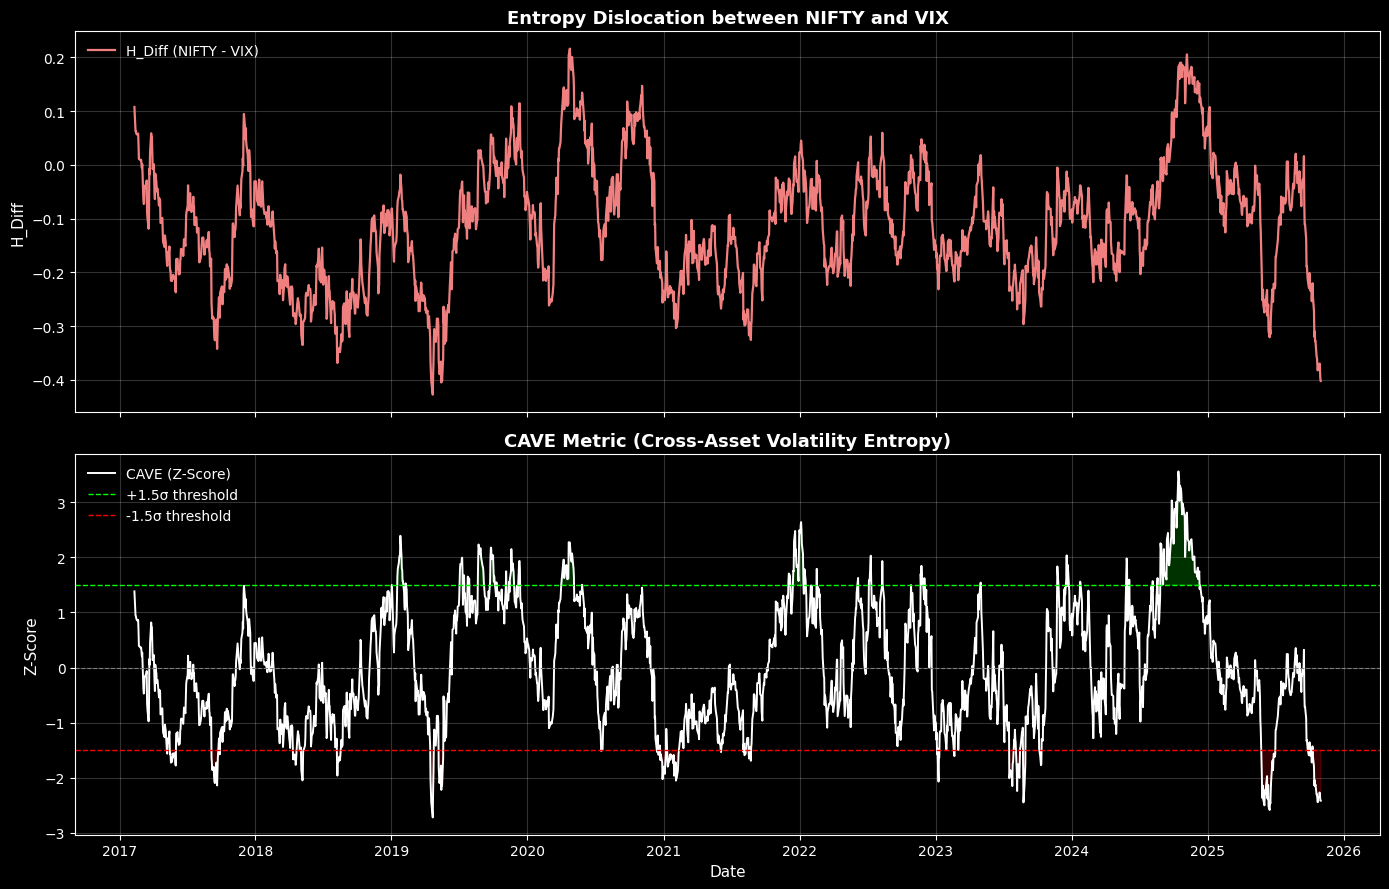

In [14]:
import matplotlib.pyplot as plt

plt.style.use("dark_background")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 9), sharex=True)

ax1.plot(entropy_df.index, entropy_df["H_DIFF"], color="lightcoral", lw=1.6, label="H_Diff (NIFTY - VIX)")
ax1.set_title("Entropy Dislocation between NIFTY and VIX", fontsize=13, weight="bold")
ax1.set_ylabel("H_Diff", fontsize=11)
ax1.legend(loc="upper left", frameon=False)
ax1.grid(alpha=0.2)

ax2.plot(entropy_df.index, entropy_df["CAVE"], color="white", lw=1.4, label="CAVE (Z-Score)")
ax2.axhline(0, color="gray", lw=0.8, linestyle="--")
ax2.axhline(1.5, color="lime", lw=1, linestyle="--", label="+1.5σ threshold")
ax2.axhline(-1.5, color="red", lw=1, linestyle="--", label="-1.5σ threshold")

ax2.fill_between(entropy_df.index, 1.5, entropy_df["CAVE"],
                 where=entropy_df["CAVE"] > 1.5, color="lime", alpha=0.2)
ax2.fill_between(entropy_df.index, -1.5, entropy_df["CAVE"],
                 where=entropy_df["CAVE"] < -1.5, color="red", alpha=0.2)

ax2.set_title("CAVE Metric (Cross-Asset Volatility Entropy)", fontsize=13, weight="bold")
ax2.set_xlabel("Date", fontsize=11)
ax2.set_ylabel("Z-Score", fontsize=11)
ax2.legend(loc="upper left", frameon=False)
ax2.grid(alpha=0.2)

plt.tight_layout()
plt.show()
